In [1]:
#Load modules

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from numpy.random import choice 
from numpy import where, power


In [2]:
geo = 'CHI_COM'

var_dict = {'name': ['Wages', 'Output', 'Exports', 'Imports'], 
       'dataset': ['prd','prd', 'trd', 'trd'], 
       'levels': [['CI1', 'CI2', 'CI4'],['CI1', 'CI2', 'CI4'], ['HS1', 'HS2', 'HS4'], ['HS1', 'HS2', 'HS4']],
#            'agg_ref' : [CIIU, CIIU, HS, HS],
           'agg_str' : ['CIIU','CIIU', 'HS', 'HS']}

hard_drive_path = './../../../../../media/miglesia/Elements/Matias_Iglesias_Backup/miglesia/Documents/compute-corr-structures/'
path = 'data/disagg_struct_refs/formatted/'


# GEO_chi = pd.read_csv('data/disagg_struct_refs/formatted/GEO_chi.csv')

def add_theme_attribute_column(nodes):

    node_attribute_datasets = []

    for ds in datasets:
        df = nodes[[col for col in nodes.columns if ds['ID'][:-3] in col]]

        if len(set(df.columns)) > 1: #two variables in this dataset are on diff levels

            df_x = df.merge(ds['ref'].drop_duplicates(subset = df.columns[0]), 
                            on  = df.columns[0], how = 'left', suffixes=('_x', ''))
            df_x['att_B_x'] = df_x[ds['ID']].map(ds['dict'])

            df_y = df.merge(ds['ref'].drop_duplicates(subset = df.columns[1]), 
                            on  = df.columns[1], how = 'left', suffixes=('_x', ''))
            df_y['att_B_y'] = df_y[ds['ID']].map(ds['dict'])

            # Column with values of thematic labels, from entries of 'HS' ('CIIU') dataset
#             df_ds = df_x[['att_B_x']].fillna(df_y[['att_B_y']])
            df_ds = pd.DataFrame(where(df_x.att_B_x.isnull(), df_y.att_B_y, df_x.att_B_x), columns = ['att_B'])

        else:
            df_ = df.merge(ds['ref'].drop_duplicates(subset = df.columns[0])
                           , how = 'left')
            df_ds = pd.DataFrame(df_[ds['ID']].map(ds['dict']))

        df_ds.columns = ['att_B']

        node_attribute_datasets += [df_ds]
#         print len(df_ds)

    att_B = node_attribute_datasets[0].fillna(node_attribute_datasets[1])

    nodes['att_B'] = att_B.fillna('Others')
    
    return nodes

CIIU = pd.read_csv(path+'CIIU_full.csv')
HS = pd.read_csv(path+'hs_full.csv').astype(str)
HS[[col for col in HS.columns if 'HS ID' in col]] = HS[[col for col in HS.columns if 'HS ID' in col]].astype('int')

HS_cats_dict = {1: 'Vegetables, animals, wood', 2: 'Vegetables, animals, wood', 3: 'Vegetables, animals, wood', 
     4: 'Vegetables, animals, wood', 9: 'Vegetables, animals, wood', 10: 'Vegetables, animals, wood', 
     5: 'Minerals, metals', 14: 'Minerals, metals', 15: 'Minerals, metals',  
     11: 'Textiles', 12: 'Textiles',
     16: 'Manufacture, machinery', 17: 'Manufacture, machinery', 18: 'Manufacture, machinery', 19: 'Manufacture, machinery', 20: 'Manufacture, machinery'}
CIIU_cats_dict = {'A': 'Vegetables, animals, wood', 'B': 'Minerals, metals', 'C': 'Fabrication', 'G': 'Commerce', 'O': 'Public sector'}


datasets = [{'ref': HS,'ID':'HS ID HS1', 'dict': HS_cats_dict},
               {'ref': CIIU, 'ID':'CIIU ID CI1', 'dict': CIIU_cats_dict }]


In [4]:
# edges_max_d = df1.merge(df2, on = ['index_x', 'index_y', 'weight_'+geo]).reset_index(drop = True)
# df2
# df1.merge(df2, on = ['index_x', 'label_x', 'index_y', 'label_y', 'weight_'+geo])

In [24]:
import networkx as nx

max_d = 10
k = 0.05
max_degrees = [4, 7, 10, 20, 40]
k = [.02, .05, 0.09, .11, .15]
k = [.02, .05, 0.06, .10, .16]
l = len(max_degrees)


# files = glob.glob('./Figures/6_neighbhoods/*')
path = 'data/new/'

conf = ('CI4', 'CI4', 'HS4', 'HS2')

#     (CIIU_lev, HS_Exp, HS_Imp) = conf
#     (CBO_lev, CNAE_lev, HS_Exp, HS_Imp) = conf

#     col_name = ctry_str+'_'+geo_str+'_'+'_'.join([c for c in conf])+var_str
conf_name = geo+'_'+'_'.join([var_dict['name'][m][0]+conf[m][2::2] for m in range(len(var_dict['name']))])

#             print conf_name

# nodes = pd.read_csv(hard_drive_path+path+conf_name+'_nodes.csv', index_col = 0).sort_index().reset_index()
nodes = pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/nodes_bs.csv').sort_index().reset_index().rename({'Unnamed: 0': 'node_name'}, axis = 1)

nodes = nodes.sort_index()

rainbow_colors = {1:'#FFB6C1', #Violet
2:'#9400D3', #Indigo
3:'#0000FF', #Blue
4:'#00FF00', #Green
5:'#D3D3D3', #Gray
6:'#FFFF00', #Yellow
7:'#FF7F00', #Orange
8:'#FF0000'} #Red


# edges = pd.read_csv(hard_drive_path+path+conf_name+'_edges.csv', index_col = 0)[['label_x', 'label_y', 'weight_CHI_COM']]
edges = pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_edges_bs.csv', index_col = 0)[['label_x', 'label_y', 'weight_CHI_COM']]
edges = edges.merge(nodes['node_name'].reset_index(), left_on='label_x', right_on='node_name').merge(
    nodes['node_name'].reset_index(), left_on='label_y', right_on='node_name')[['index_x', 'label_x', 'index_y', 'label_y', 'weight_CHI_COM']]



    #     Add info of districts with most volume (CHI)
###
# From concat data get node value totals

df = pd.read_csv(hard_drive_path+path+conf_name+'_cc_data.csv', index_col = 'node_name')
df['node_value_USD'] = df.groupby('node_name')[['value_USD']].sum()

df = df.reset_index()

#     ###

#color
from matplotlib import colors

nodes = add_theme_attribute_column(nodes) #add gross thematic attributes, function is written below

nodes['color_code'] = nodes.att_B.rank(method = 'dense') #or att_B

nodes['color'] = pd.DataFrame(nodes['color_code'].map(rainbow_colors))

value = nodes['node_value_USD']
# nodes['node_size'] = np.sqrt((value/value.median()).values)
nodes['node_size'] = power((value/value.median()).values, 1/2.)
nodes['node_size'] = 30*nodes['node_size']/nodes['node_size'].median()

#     nodes = nodes.merge(code_hex)
max_d = 20

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges.groupby('index_x').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
df2 = edges.groupby('index_y').apply(lambda x: x.nlargest(max_d, 'weight_'+geo)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['index_x', 'label_x', 'index_y', 'label_y', 'weight_'+geo]).reset_index(drop = True)

###

G = nx.from_pandas_edgelist(edges_max_d, 'index_x', 'index_y', 'weight_'+geo)

# Subset of nodes
# nodes_s = nodes.loc[G.nodes()]



#Perform Graph Drawing
# for k in [.3, .2, .1, .05]:

#     pos = nx.spring_layout(G, k=k)

#     plt.figure(figsize = (10, 8))

#     nx.draw(G, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
#     nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
#     plt.title('max_d = '+str(max_d))
#     plt.title(conf_name+'\n max_degree = '+str(max_d))
#     #     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#     #             plt.show()

#     plt.show()




In [25]:
# Prune graph by keeping only triangles

done=set()    #
result=[]
for n in G:
    done.add(n)    #
    nbrdone=set()    #
    nbrs=set(G[n])
    for nbr in nbrs:
        if nbr in done:    #
            continue    #
        nbrdone.add(nbr)    #
        for both in nbrs.intersection(G[nbr]):
            if both in done or both in nbrdone:    #
                continue    #
            result.append( (n,nbr) )
            result.append( (nbr,both) )
            result.append( (n,both) )
# print result

G =  nx.create_empty_copy(G, with_data=True)
G.add_edges_from(result)

In [50]:
# G=nx.Graph()
# G.add_nodes_from([1, 2, 3, 4, 5, 6])
# G.add_edges_from([(1,2),(2,3),(2,4),(2,5),(3,4),(3,6),(4,6)])

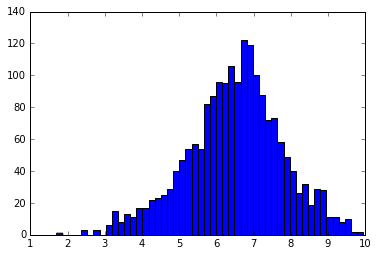

In [109]:
from numpy import log10
plt.hist(log10(nodes['node_value_USD']).values, 50)
plt.show()

In [21]:
print nodes.groupby('Variable')['node_value_USD'].sum()

Variable
Exports    1.486418e+10
Imports    1.247512e+10
Output     1.389312e+11
Wages      1.916412e+10
Name: node_value_USD, dtype: float64


In [22]:
print nodes.groupby('Variable')['node_value_USD'].sum()

Variable
Exports    1.486418e+10
Imports    1.247512e+10
Output     1.389312e+11
Wages      1.916412e+10
Name: node_value_USD, dtype: float64


In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

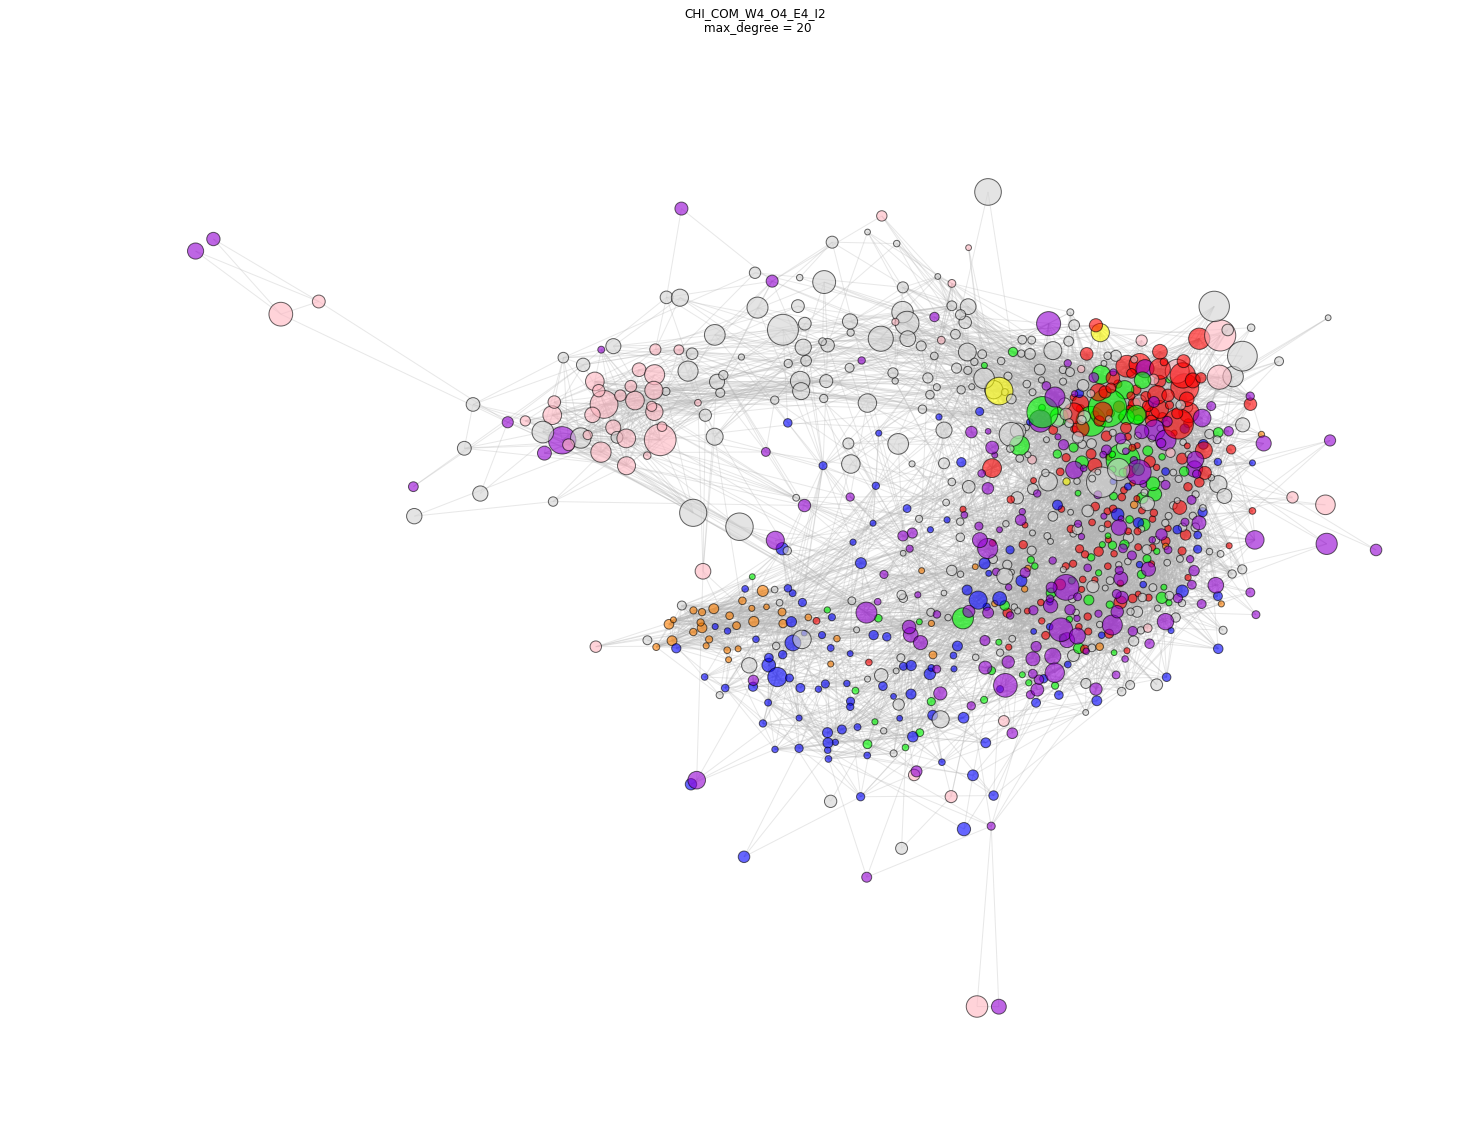

In [26]:
# Hard threshold and max degree backboning

plt.figure(figsize = (20, 15))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.1)

nx.draw(G, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.title('max_d = '+str(max_d))
plt.title(conf_name+'\n max_degree = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()




## Michelle's backboning

In [14]:
import sys
sys.path.append("./../visualization-notebook-templates/") # for HH tools
sys.path.append("./../Hidalgo_Haussmann") # for HH tools

import backboning as bb


edges_bb = edges[['index_x', 'index_y', 'weight_CHI_COM']].rename({'index_x': 'src', 'index_y': 'trg'}, axis = 1)#.to_csv('edges_bb_test.csv', index = False)
edges_bb.to_csv('edges_bb_test.csv', index = False)

In [15]:
for threshold in [6.81,]:
# for threshold in [5.81,]:
    table, nnodes, nnedges = bb.read('edges_bb_test.csv', "weight_CHI_COM", sep = ',')
    nc_table = bb.noise_corrected(table)
    nc_backbone = bb.thresholding(nc_table, threshold)
    print len(nc_backbone)
    print nnodes
# backboning.write(nc_backbone, "network_name", "nc", "/path/to/output")

Index([u'src', u'trg', u'weight_CHI_COM'], dtype='object')
Index([u'src', u'trg', u'nij'], dtype='object')
14104
871


Calculating NC score...


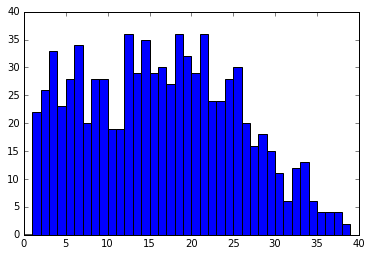

In [16]:
plt.hist(nc_backbone.groupby('src').count()['score'].sort_values(), range(40))
plt.show()

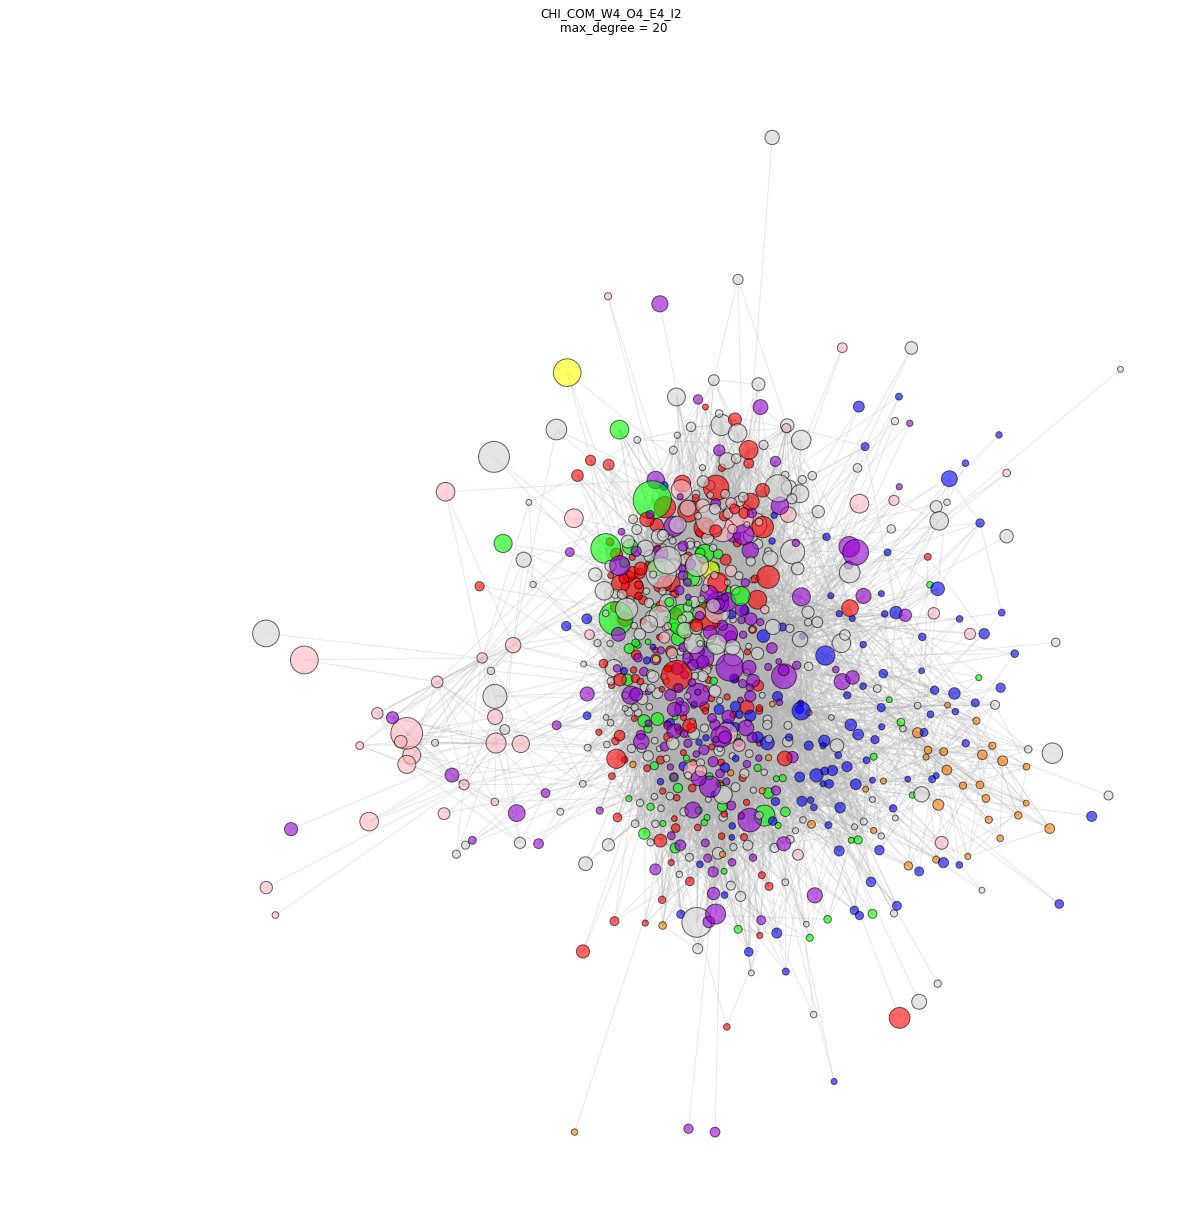

In [18]:

G = nx.from_pandas_edgelist(nc_backbone, 'src', 'trg', 'score')
G = max(nx.connected_component_subgraphs(G), key=len)

plt.figure(figsize = (16, 16))

pos = nx.spring_layout(G, k=.05)

nx.draw(G, pos, node_size = nodes_s.node_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
plt.title('max_d = '+str(max_d))
plt.title(conf_name+'\n max_degree = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [39]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1)

In [40]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'node_name', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 2000 * nodes_[['x', 'y']]


In [41]:
import sys
sys.path.append("./modules/") # for d3plus2
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import d3plus2 as d3plus
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [42]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.index_x, edges_max_d.index_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.index_y, edges_max_d.index_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({'weight_CHI_COM': 'strength'},axis = 1)
links['target'] = links['index_y'].astype(str).str.zfill(4)
links['source'] = links['index_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)


network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [43]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [48]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

### Color by Population Density

In [32]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [33]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [46]:
pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'node_name'})
nodes_ = nodes_.merge(pop_dens_index, on = 'node_name', how = 'left')
nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

from numpy import nan
rainbow_colors = {0:'#9400D3', #Violet
1:'#4B0082', #Indigo
2:'#0000FF', #Blue
3:'#00FF00', #Green
nan:'#D3D3D3',  #'#D3D3D3', #Gray
4:'#FFFF00', #Yellow
5:'#FF7F00', #Orange
6:'#FF0000'} #Red

nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [47]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

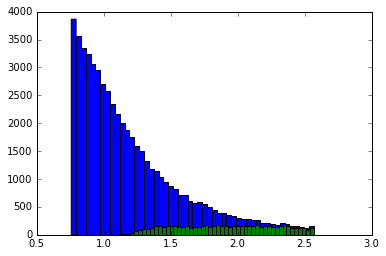

In [53]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()